***Voter Inequality in Canada***

In [92]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Define some helper functions for parsing the 308.com data

In [2]:
def read_file(filename):
    f = open(filename, 'r')
    abc = f.readlines()
    f.close()
    return abc

def tab_separate(contents):
    xyz = []
    for a in contents:
        b = a.split("\t")
        xyz.append(b)
    return xyz

def remove_non_data_lines(sep_contents):
    a1 = []
    for x in sep_contents:
        if len([y for y in x if y == '']) < 2:
            a1.append(x)
    return a1

def get_riding_names(clean_contents):
    ridings = []
    for i in range(338):
        ridings.append(clean_contents[i*3+1][0])
    return ridings

Parse the 308.com data

In [3]:
abc = read_file('current_projections.txt')
xyz = tab_separate(abc)
a1 = remove_non_data_lines(xyz)
ridings = get_riding_names(a1)

In [4]:
import fednum_dict as fed

In [5]:
a2 = {v: k for k, v in fed.fednum_dict.items()} 

Manually set some ridings that are difficult to get automatically

In [6]:
found = {}
found['Haliburton – Kawaratha Lakes – Brock'] = 35034
found['Ahuntsic – Cartierville'] = 24003
found['Laval-Les \xceles'] = 24040 
found['Mont-Royal'] = 24052 
found["Ville-Marie – Le Sud-Ouest – L'Île-des-Soeurs"] = 24077 
found["Beauport – Côte-de-Beaupré – Île d'Orléans – Charlevoix"] = 24020
found['Portneuf – Jacques Cartier'] = 24058
found["South Shore – St. Margaret's"] = 12009

In [97]:
not_found = []
for r in ridings:
    if r not in found:
        if r in a2:
            #Riding is easily found in the 308.com data, add to dictionary
            found[r] = a2[r]
        else:
            #Try stripping astrix
            new = r.strip('*')
            if new in a2:
                found[r] = a2[new]
            else:
                #Failed to find the riding
                not_found.append(r)

Some sanity checking for the parsing

In [8]:
not_found

[]

In [9]:
len(found)

338

In [10]:
len(not_found)

0

In [11]:
len(set(found.keys()))

338

In [12]:
len(set(found.values()))

338

ridingForecast.py contains some classes for storing party forecasts and riding forecasts

In [13]:
import ridingForecast

In [14]:
ridingDict = ridingForecast.parseCleanForecasts(a1)

In [15]:
print(ridingDict['Mont-Royal'])

Mont-Royal
Winner: ('Liberal', 47.6) prob: 0.84

Conservative Party, low = 28.5, forecast = 30.0, high = 33.0
Liberal Party, low = 42.8, forecast = 47.6, high = 50.9
New Democratic Party, low = 17.2, forecast = 17.9, high = 19.3
Bloc Quebecois Party, low = 1.4, forecast = 1.6, high = 1.7
Green Party, low = 0.0, forecast = 0.0, high = 0.0
Other Party, low = 2.1, forecast = 2.4, high = 2.5


In [16]:
#Make sure all the ridings are in the dictionary
all([r in ridingDict for r in ridings])

True

Read in the Statistics Canada population data for the ridings

In [17]:
populations = pd.read_csv('ridingPopulations.csv')
populations.head()

,Riding,RidingName,Population
0,10001,Avalon,81540
1,10002,Bonavista–Burin–Trinity,76704
2,10003,Coast of Bays–Central–Notre Dame,78092
3,10004,Labrador,26728
4,10005,Long Range Mountains,87592


In [18]:
for riding in ridings:
    ridingDict[riding].population = float(populations[populations['Riding'] == found[riding]]['Population'])

The function for the value of a vote assumes that a voter forecast to cast a tie breaking vote in a riding has value 1.0. The value of other votes is 1.0 divided by the number of times they would need to vote for their party to win.

In [44]:
def voteValue(partyName, ridingFC):
    if partyName == ridingFC.getWinner()[0]:
        delta = ridingFC.getForecast(partyName) - ridingFC.getSecond()[1]
    else:
        delta = ridingFC.getWinner()[1] - ridingFC.getForecast(partyName)
    return 100.0/max(100.0,ridingFC.population*delta)

In [45]:
conValues = [(riding, voteValue("Conservative", ridingDict[riding])) for riding in ridings]
libValues = [(riding, voteValue("Liberal", ridingDict[riding])) for riding in ridings]
ndpValues = [(riding, voteValue("New Democratic", ridingDict[riding])) for riding in ridings]
blocValues = [(riding, voteValue("Bloc Quebecois", ridingDict[riding])) for riding in ridings]
greenValues = [(riding, voteValue("Green", ridingDict[riding])) for riding in ridings]
otherValues = [(riding, voteValue("Other", ridingDict[riding])) for riding in ridings]
#print(greenValues)
#print(sorted(ndpValues, key=lambda x: x[1]))

In [46]:
min(ndpValues, key=lambda x: x[1])

('Vancouver Quadra', 1.6273498932458474e-05)

In [48]:
parties = ["Conservative", "Liberal", "New Democratic", "Bloc Quebecois", "Green", "Other"]

In [53]:
totalpop = sum([ridingDict[riding].population for riding in ridings])

Here we create an array containing the voting values of one in one thousand Canadian voters

In [81]:
voterPowers = np.zeros(32521)
i = 0
for riding in ridings:
    for party in parties:
        for person in range(
            int(ridingDict[riding].getForecast(party)/100.0
                *ridingDict[riding].population/1000.0)):
            voterPowers[i] = voteValue(party, ridingDict[riding])
            i += 1
            

The Lorenz curve is a common way of displaying inequality in a distribution. This function computes the values of the Lorenz curve.

In [86]:
def Lorenz(values):
    n = len(values)
    assert(n > 0), 'Empty list of values'
    sortedValues = sorted(values) #Sort smallest to largest

    #Find cumulative totals
    cumm = np.zeros(n+1)
    for i in range(n+1):
        cumm[i] = sum(sortedValues[0:(i + 1)])

    #Calculate Lorenz points
    LorenzPoints = [[], []]
    for i in range(1, n + 2):
        x = 100.0 * (i - 1)/n
        y = 100.0 * (cumm[i - 1]/float(cumm[n]))
        LorenzPoints[0].append(x)
        LorenzPoints[1].append(y)
    

    return LorenzPoints

In [87]:
len(voterPowers)

32521

In [88]:
lorenzPoints = Lorenz(voterPowers)

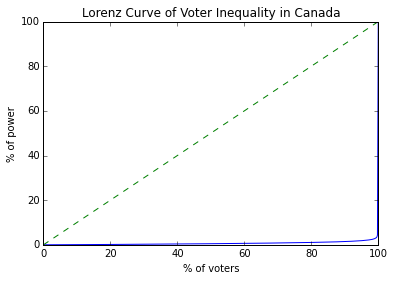

In [98]:
plt.plot(lorenzPoints[0], lorenzPoints[1], [0, 100], [0, 100], '--')
plt.xlabel('% of voters')
plt.ylabel('% of power')
plt.title("Lorenz Curve of Voter Inequality in Canada")
plt.show()

In [95]:
def gini(list_of_values):
  sorted_list = sorted(list_of_values)
  height, area = 0, 0
  for value in sorted_list:
    height += value
    area += height - value / 2.
  fair_area = height * len(list_of_values) / 2
  return (fair_area - area) / fair_area

In [96]:
print(gini(voterPowers))

0.984672280601
